# Moment Curvature Analysis of Section

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import openseespy.opensees as ops

import opstool as opst


## Create Section

.. Note::
    This step is not mandatory. 
    You can also use your own section, as the subsequent analysis only requires the section tag.

Note that you need to set the model to 6DOF in 3D, because the program takes two axes into account.

Create any opensees material yourself as follows:

In [2]:
def create_section():
    ops.wipe()
    ops.model("basic", "-ndm", 3, "-ndf", 6)
    # materials
    Ec = 3.55e7
    # Vc = 0.2
    # Gc = 0.5 * Ec / (1 + Vc)
    fc = -32.4e3
    ec = -2000.0e-6
    ecu = 2.1 * ec
    ft = 2.64e3
    et = 107e-6
    fccore = -40.6e3
    eccore = -4079e-6
    ecucore = -0.0144
    Fys = 300.0e3
    Es = 2.0e8
    bs = 0.01
    matTagC = 1
    matTagCCore = 2
    matTagS = 3
    # for cover
    ops.uniaxialMaterial("Concrete04", matTagC, fc, ec, ecu, Ec, ft, et)
    # for core
    ops.uniaxialMaterial("Concrete04", matTagCCore, fccore, eccore, ecucore, Ec, ft, et)
    ops.uniaxialMaterial(
        "Steel01",
        matTagS,
        Fys,
        Es,
        bs,
    )
    outlines = [[0, 0], [2, 0], [2, 2], [0, 2]]
    coverlines = opst.pre.section.offset(outlines, d=0.05)
    cover = opst.pre.section.create_polygon_patch(outlines, holes=[coverlines])
    holelines = [[0.5, 0.5], [1.5, 0.5], [1.5, 1.5], [0.5, 1.5]]
    core = opst.pre.section.create_polygon_patch(coverlines, holes=[holelines])
    SEC = opst.pre.section.FiberSecMesh()
    SEC.add_patch_group({"cover": cover, "core": core})
    SEC.set_mesh_size({"cover": 0.1, "core": 0.1})
    SEC.set_mesh_color({"cover": "gray", "core": "green"})
    SEC.set_ops_mat_tag({"cover": matTagC, "core": matTagCCore})
    SEC.mesh()
    # add rebars
    rebar_lines = opst.pre.section.offset(outlines, d=0.05 + 0.032 / 2)
    SEC.add_rebar_line(
        points=rebar_lines,
        dia=0.02,
        gap=0.1,
        color="red",
        ops_mat_tag=matTagS,
    )
    SEC.get_frame_props(display_results=False)
    SEC.centring()
    # sec.rotate(45)
    return SEC

Plot the section mesh:

OPSTOOL :: The section My Section has been successfully meshed!

<Axes: title={'center': 'My Section'}, xlabel='y', ylabel='z'>

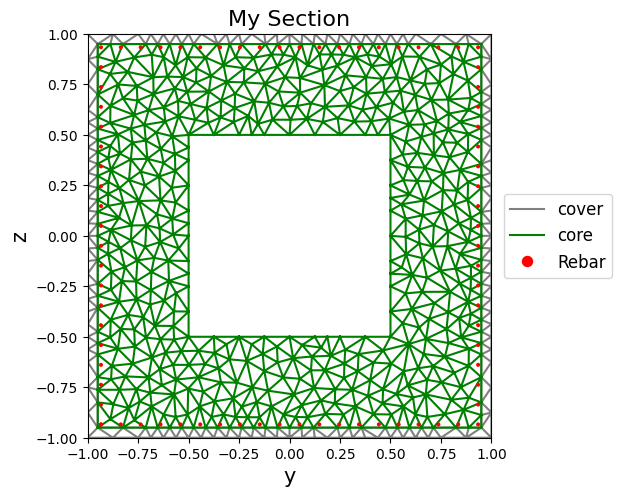

In [3]:
SEC = create_section()
SEC.view(fill=False)

Generate the OpenSeesPy commands to the domin (important!)

In [4]:
sec_tag = 1
SEC.to_opspy_cmds(secTag=sec_tag, GJ=100000)

## Monotonically Moment-Curvature Analysis

Now you can perform a moment-curvature analysis:

In [5]:
MC = opst.anlys.MomentCurvature(sec_tag=1, axial_force=-20000)
MC.analyze(axis="y", max_phi=0.1, incr_phi=1e-4, limit_peak_ratio=0.8, smart_analyze=True)

🚀 OPSTOOL::SmartAnalyze: 100%|██████████| 483/483 [00:00<00:00, 1462.96 step/s] 

Note: OpenSees LogFile has been generated in .SmartAnalyze-OpenSees.log.
MomentCurvature: 🎉 Successfully finished! 🎉


Plot the moment-curvature relationship:

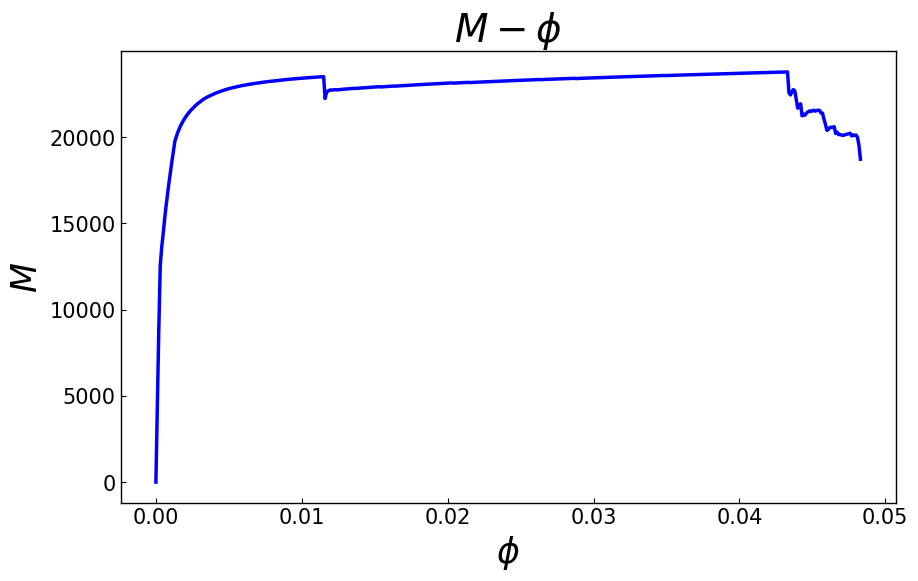

In [6]:
MC.plot_M_phi()
plt.show()

Plot all fiber stress-strain responses:

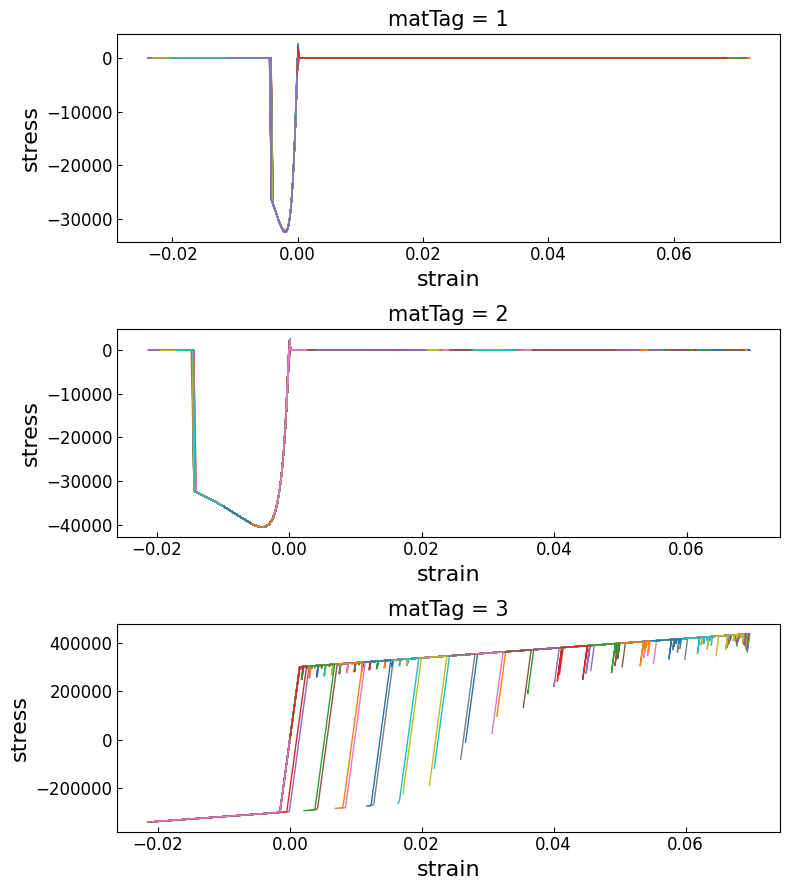

In [7]:
MC.plot_fiber_responses()
plt.show()

In [8]:
# Get moment-curvature data
phi, M = MC.get_M_phi()
# Get fiber responses data
fiber_data = MC.get_fiber_data()

fiber_data is an ``xarray.DataArray`` structure.
``"Steps"`` is the number of steps in the analysis. 
``"Fibers"`` is the number of fibers in the section. 
``"Properties"`` is the properties of the fibers, including "yloc", "zloc", "area", "mat", "stress", "strain".

In [9]:
print("Fiber data:", fiber_data)

Fiber data: <xarray.DataArray 'FiberData' (Steps: 484, Fibers: 1199, Properties: 6)> Size: 28MB
array([[[-0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        ...,
        [-0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
        [-0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, -0.00000000e+00, -0.00000000e+00]],

       [[-9.66666667e-01,  8.62500000e-01,  1.56250000e-03,
          1.00000000e+00, -3.50440123e+03, -1.01445263e-04],
        [-4.09375000e-01, -9.83333333e-01,

In [10]:
fiber_data_last = fiber_data.isel(Steps=-1)
y = fiber_data_last.sel(Properties="yloc")
z = fiber_data_last.sel(Properties="zloc")
points = np.stack((y.values, z.values)).T
matTag = fiber_data_last.sel(Properties="mat")
stress = fiber_data_last.sel(Properties="stress")
strain = fiber_data_last.sel(Properties="strain")

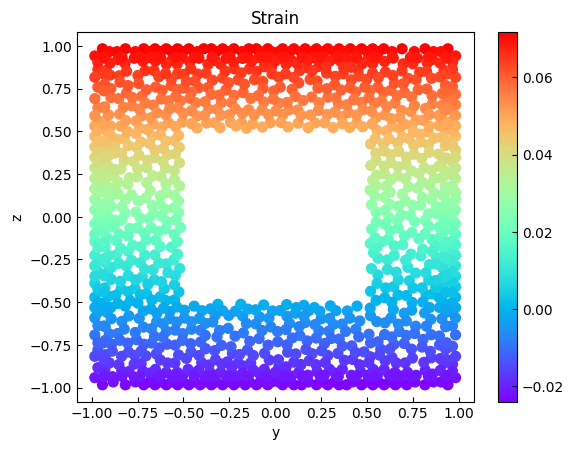

In [11]:
plt.figure()
s = plt.scatter(y, z, c=strain, s=50, cmap="rainbow")
plt.colorbar(s)
plt.xlabel("y")
plt.ylabel("z")
plt.title("Strain")
plt.show()

We can also use the ``plot_response`` method provided by ``SecMesh`` to visualize the mesh more aesthetically pleasingly.

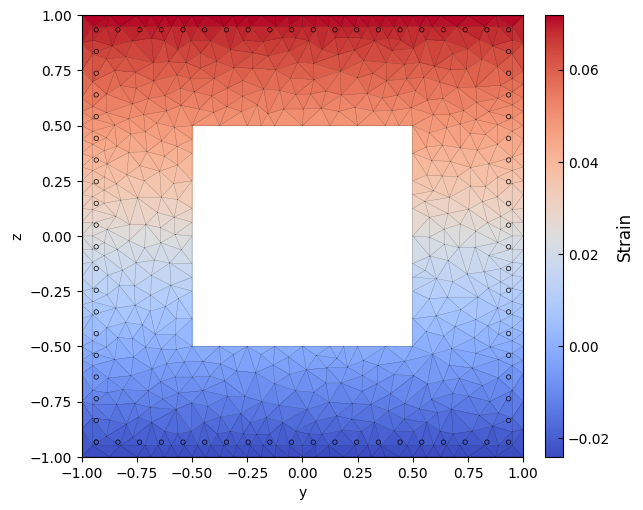

In [12]:
ax, cbar = SEC.plot_response(
    points,
    response=strain,
    mat_tag=None,
    # thresholds={1: (-0.006, 0.002), 2: (-0.015, 0.002), 3: (-0.1, 0.1)}
)
cbar.set_label("Strain", fontsize=12)
plt.show()


In [13]:
import imageio.v2 as imageio

mat = fiber_data.sel(Properties="mat", Steps=0)
cond = (matTag == 1) | (matTag == 2)  # concrete fibers only
# overall min strain across all time steps
vmin = fiber_data.sel(Properties="strain", Fibers=cond.values).min().values
# overall max strain across all time steps
vmax = fiber_data.sel(Properties="strain", Fibers=cond.values).max().values

with imageio.get_writer("data/fiber-section-strain.gif", mode="I", fps=20) as writer:
    for t in range(len(fiber_data["Steps"])):
        strain = fiber_data.sel(Properties="strain").isel(Steps=t)

        fig, ax = plt.subplots(figsize=(6, 5))
        ax, cbar = SEC.plot_response(
            points=points,
            response=strain,
            cmap="Spectral_r",
            ax=ax,
            mat_tag=[1, 2],  # concrete fibers only
            thresholds={
                1: (-0.006, 0.002),
                2: (-0.015, 0.002),
            },  # failure thresholds, 2: cover, 1: core
        )
        cbar.set_label("Strain", fontsize=12)
        cbar.mappable.set_clim(vmin, vmax)
        ax.set_title("Strain Distribution", fontsize=14)
        ax.set_xlabel("Y", fontsize=12)
        ax.set_ylabel("Z", fontsize=12)
        fig.tight_layout(rect=[0, 0, 1, 1])

        # Convert Matplotlib figure to image and append to gif
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        image = image.reshape((*fig.canvas.get_width_height()[::-1], 4))
        writer.append_data(image)

        plt.close(fig)

![fiber-section-strain](data/fiber-section-strain.gif)

In [14]:
import imageio.v2 as imageio

mat = fiber_data.sel(Properties="mat", Steps=0)
cond = (matTag == 1) | (matTag == 2)  # concrete fibers only
# overall min strain across all time steps
vmin = fiber_data.sel(Properties="stress", Fibers=cond.values).min().values
# overall max strain across all time steps
vmax = fiber_data.sel(Properties="stress", Fibers=cond.values).max().values

with imageio.get_writer("data/fiber-section-stress.gif", mode="I", fps=20) as writer:
    for t in range(len(fiber_data["Steps"])):
        stress = fiber_data.sel(Properties="stress").isel(Steps=t)

        fig, ax = plt.subplots(figsize=(6, 5))
        ax, cbar = SEC.plot_response(
            points=points,
            response=stress,
            cmap="Spectral_r",
            ax=ax,
            mat_tag=[1, 2],  # concrete fibers only
        )
        cbar.set_label("Stress", fontsize=12)
        cbar.mappable.set_clim(vmin, vmax)
        ax.set_title("Stress Distribution", fontsize=14)
        ax.set_xlabel("Y", fontsize=12)
        ax.set_ylabel("Z", fontsize=12)
        fig.tight_layout(rect=[0, 0, 1, 1])

        # Convert Matplotlib figure to image and append to gif
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        image = image.reshape((*fig.canvas.get_width_height()[::-1], 4))
        writer.append_data(image)

        plt.close(fig)

![fiber-section-stress](data/fiber-section-stress.gif)

Extract limit state points based on fiber strain thresholds or other criteria.

In [15]:
# Tensile steel fibers yield (strain=2e-3) for the first time
phiy, My = MC.get_limit_state(
    matTag=3,  # Steel material tag
    threshold=2e-3,
)
# The concrete fiber in the confined area reaches the ultimate compressive strain 0.0144
phiu, Mu = MC.get_limit_state(matTag=2, threshold=-0.0144, peak_drop=False)
# or use peak_drop
# phiu, Mu = mc.get_limit_state(matTag=2,
#                               threshold=-0.0144,
#                               peak_drop=0.2
#                              )

print(f"Limit state 1: phi_y={phiy:.4f}, My={My:.2f}")
print(f"Limit state 2: phi_u={phiu:.4f}, Mu={Mu:.2f}")

Limit state 1: phi_y=0.0017, My=20680.00
Limit state 2: phi_u=0.0434, Mu=22576.93


Equivalent linearization according to area:

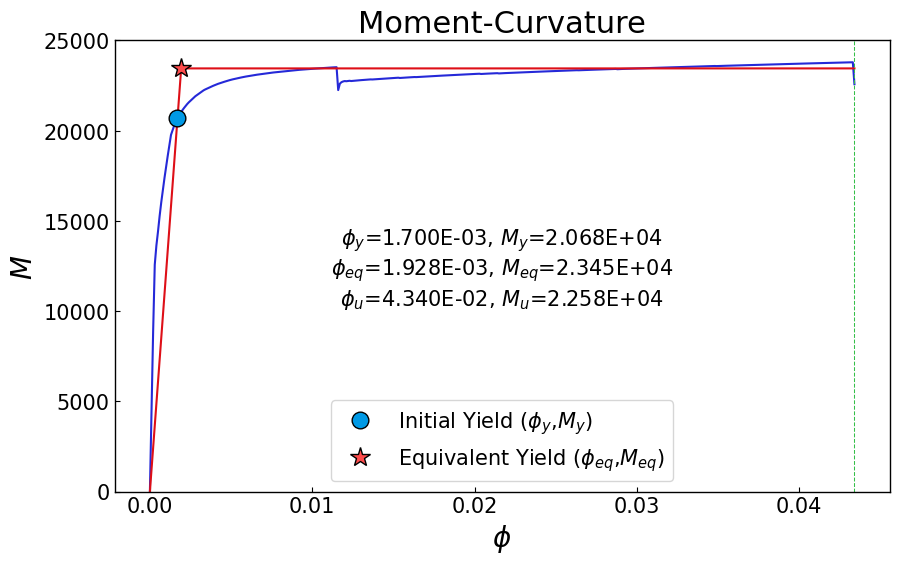

In [16]:
phi_eq, M_eq = MC.bilinearize(phiy, My, phiu, plot=True)
plt.show()

## Cycle Moment-Curvature Analysis

In [17]:
SEC = create_section()
sec_tag = 1
SEC.to_opspy_cmds(secTag=sec_tag, GJ=100000)

OPSTOOL :: The section My Section has been successfully meshed!

In [18]:
MC = opst.anlys.MomentCurvature(sec_tag=1, axial_force=-20000)
MC.set_cycle_path(max_phi=0.04, n_cycle=20, n_hold=2)
MC.analyze(
    axis="y",
    cycle_analyze=True,
    incr_phi=1e-3,
    limit_peak_ratio=0.8,
    smart_analyze=True,
)

🚀 OPSTOOL::SmartAnalyze: 100%|██████████| 2850/2850 [00:02<00:00, 1424.00 step/s]


Note: OpenSees LogFile has been generated in .SmartAnalyze-OpenSees.log.
MomentCurvature: 🎉 Successfully finished! 🎉


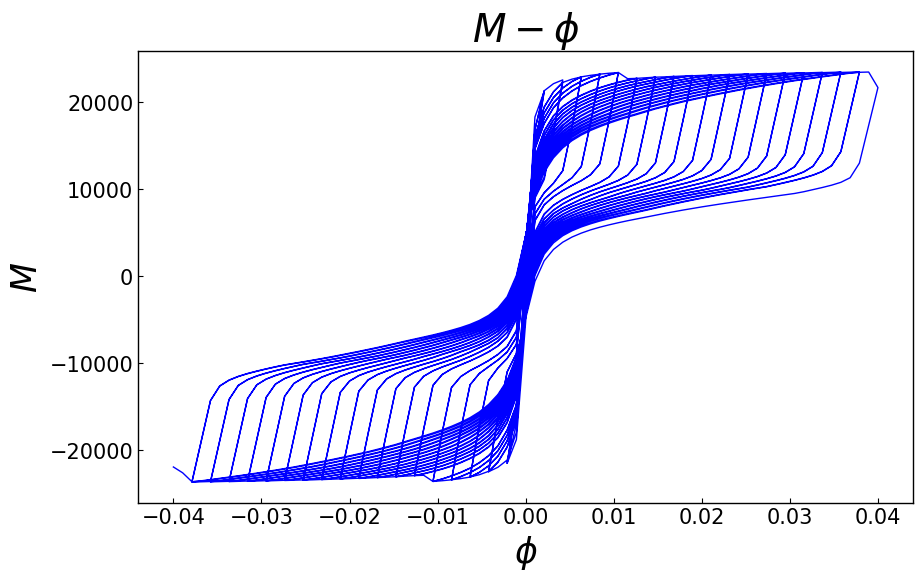

In [19]:
MC.plot_M_phi()
plt.show()